# Identifying Entities in Healthcare Data

##Workspace set up: Import and Install useful packages.

In [147]:
!pip install pycrf
!pip install sklearn-crfsuite

##Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

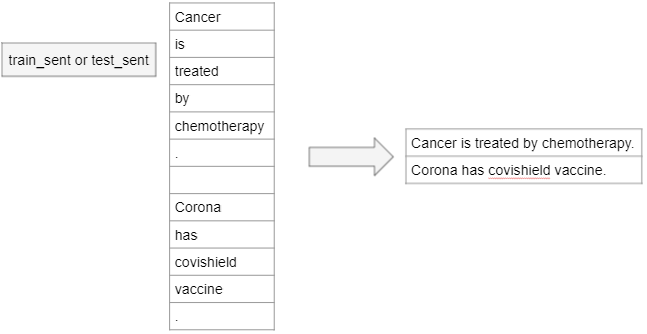

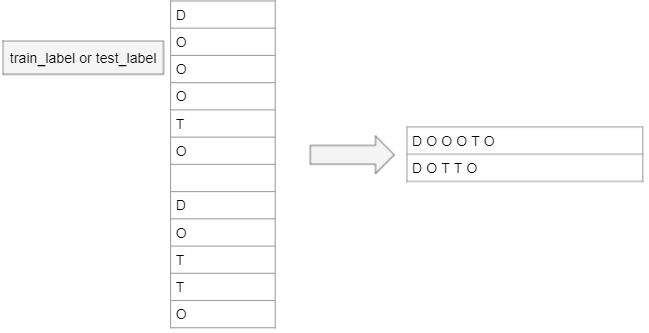

In [148]:
# Importing libraries
import spacy
import textwrap
import warnings
import json
import sklearn_crfsuite

import pandas as pd

from tqdm import tqdm
from sklearn_crfsuite import metrics

warnings.filterwarnings("ignore")
model = spacy.load("en_core_web_sm")

In [149]:
# Function to read the file if given filename
def read_file(file_name):
    with open(file_name, 'r', encoding='utf-8') as file:
        content = file.readlines()
    
    sentences = []
    sentence = ""
    word_count = 0
    
    for word in content:
        word = word.strip('\n')
        if word == "":
            sentences.append(sentence.rstrip(" "))
            sentence = ""
        else:
            word_count += 1
            sentence += word + " "
            
    print("Items in File       : ", len(content))
    print("Number of Words     : ", word_count)
    print("Number of Sentences : ", len(sentences))
    
    prefix = "First Sentence      :  "
    wrapper = textwrap.TextWrapper(initial_indent = prefix, width = 150, subsequent_indent = ' '*len(prefix))
    print(wrapper.fill(sentences[0]))
    
    return sentences

In [121]:
#def load_data_spacy(file_path):
#  with open(file_path, encoding='UTF_8') as f:
#        #declare an empty list
#        words = []
#        sentences = []

        #loop through lines
#        for line in f:
#          if len(line) >= 1 & line.isspace() == False:
#            word = line.strip("\n")
#            words.append(word)
#          elif line.isspace():
#            sentences.append("{}".format(" ".join(words)))
#            #empty the list
#            words = []

#  return sentences

In [122]:
#Train data set load
#Train_Data_Labels = load_data_spacy("/content/drive/MyDrive/Colab Notebooks/train_label")
#print(Train_Data_Labels[:5])
#Train_Data_Sentences = load_data_spacy("/content/drive/MyDrive/Colab Notebooks/train_sent")
#print(Train_Data_Sentences[:5])

['O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O']
['All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )', 'The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )', 'Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )', "The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )", "Arrest of dilation was the most common indication in both `` corrected '' subgroups

In [123]:
#Test data set load
#Test_Data_Labels = load_data_spacy("/content/drive/MyDrive/Colab Notebooks/test_label")
#print(Test_Data_Labels[:5])
#Test_Data_Sentences = load_data_spacy("/content/drive/MyDrive/Colab Notebooks/test_sent")
#print(Test_Data_Sentences[:5])

['O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O']
['Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 )', 'As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration', 'The daily high temperature ranged from 71 to 104 degrees F and AFI values ranged from 1.7 to 24.7 cm during the study period', 'There was a significant correlation between the 2- , 3- , and 4-day mean temperature and AFI , with the 4-day mean being the most significant ( r = 0.31 , p & # 60 ; 0.001 )', 'Fluctuations in ambient temperature are inversely correlated to changes in 

### Count the number of sentences in the processed train and test dataset 

In [150]:
print("Training Sentences")
print("------------------")
train_sentences = read_file("/content/drive/MyDrive/Colab Notebooks/train_sent")

print("\n")
print("Testing Sentences")
print("------------------")
test_sentences = read_file("/content/drive/MyDrive/Colab Notebooks/test_sent")

Training Sentences
------------------
Items in File       :  48501
Number of Words     :  45902
Number of Sentences :  2599
First Sentence      :  All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery
                       route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )


Testing Sentences
------------------
Items in File       :  19674
Number of Words     :  18618
Number of Sentences :  1056
First Sentence      :  Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks ,
                       the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 )


In [124]:
#print("Number of Train data sentences:{}".format(len(Train_Data_Sentences)))
#print("Number of Test data sentences:{}".format(len(Test_Data_Sentences)))

Number of Train data sentences:2599
Number of Test data sentences:1056


### Count the number of lines of labels in the processed train and test dataset.

In [151]:
print("Training Labels")
print("--------------")
train_labels = read_file("/content/drive/MyDrive/Colab Notebooks/train_label")

print("\n")
print("Testing Labels")
print("--------------")
test_labels = read_file("/content/drive/MyDrive/Colab Notebooks/test_label")

Training Labels
--------------
Items in File       :  48501
Number of Words     :  45902
Number of Sentences :  2599
First Sentence      :  O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O


Testing Labels
--------------
Items in File       :  19674
Number of Words     :  18618
Number of Sentences :  1056
First Sentence      :  O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O


In [125]:
#print("Number of Train data labels:{}".format(len(Train_Data_Labels)))
#print("Number of Test data labels:{}".format(len(Test_Data_Labels)))

Number of Train data labels:2599
Number of Test data labels:1056


##Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [152]:
def get_pos_tags(reviews, labels, tag = ""):
    
    sentence = []
    pos = []
    lemma = []
    text = []
    label = []
    
    i = 1 # Sentence Count
    
    for review, review_labels in tqdm(zip(reviews, labels)):
        #doc = model(review)
        for doc, review_label in zip(review.split(), review_labels.split()):
            s = model(doc)
            for tok in s:
                sentence.append(tag + str(i))
                pos.append(tok.pos_)
                lemma.append(tok.lemma_)
                text.append(tok.text)
                label.append(review_label)
        
        i += 1
    
    return sentence, pos, lemma, text, label

print("Training Sentences")
print("------------------")
train_sentence, train_pos, train_lemma, train_text, train_label = get_pos_tags(train_sentences, train_labels, "train_")
train_frequency_df = pd.DataFrame({'sentence':train_sentence, 'text':train_text,'lemma':train_lemma,'pos':train_pos,'label':train_label})

print("\n")
print("Testing Sentences")
print("------------------")
test_sentence, test_pos, test_lemma, test_text, test_label = get_pos_tags(test_sentences, test_labels, "test_")
test_frequency_df = pd.DataFrame({'sentence':test_sentence, 'text':test_text,'lemma':test_lemma,'pos':test_pos,'label':test_label})

# Convert the data into a dataframe object.
frequency_df = pd.concat((train_frequency_df.copy(), test_frequency_df.copy()),axis=0)

Training Sentences
------------------


2599it [05:29,  7.89it/s]




Testing Sentences
------------------


1056it [02:15,  7.81it/s]


In [127]:
#tokens_noun = []
#tokens_propn = []
#for x in Train_Data_Sentences:
#    doc = model(x)
#    for token in doc:
#      if token.pos_ == "NOUN":
#        tokens_noun.append(token.text)
#      elif token.pos_ == "PROPN":
#        tokens_propn.append(token.text)

In [129]:
#noun_tally = Counter(tokens_noun)
#noun_tally.most_common()

[('patients', 352),
 ('treatment', 195),
 ('%', 161),
 ('cancer', 134),
 ('therapy', 115),
 ('disease', 105),
 ('study', 101),
 ('cell', 96),
 ('lung', 77),
 ('group', 61),
 ('effects', 61),
 ('chemotherapy', 56),
 ('use', 54),
 ('results', 54),
 ('gene', 53),
 ('surgery', 51),
 ('survival', 50),
 ('risk', 49),
 ('women', 48),
 ('care', 47),
 ('analysis', 47),
 ('children', 47),
 ('activity', 47),
 ('rate', 46),
 ('cases', 46),
 ('patient', 46),
 ('years', 45),
 ('syndrome', 44),
 ('health', 44),
 ('cells', 44),
 ('combination', 43),
 ('effect', 43),
 ('response', 43),
 ('protein', 42),
 ('diagnosis', 40),
 ('data', 40),
 ('studies', 40),
 ('term', 39),
 ('bone', 38),
 ('infection', 37),
 ('trial', 37),
 ('case', 36),
 ('dose', 36),
 ('evidence', 36),
 ('age', 34),
 ('management', 34),
 ('months', 33),
 ('role', 32),
 ('stage', 30),
 ('time', 30),
 ('vaccine', 30),
 ('medicine', 29),
 ('control', 29),
 ('blood', 29),
 ('tumor', 29),
 ('methods', 28),
 ('tumors', 28),
 ('failure', 28),


### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [153]:
# Get most frequent text forms of nouns
frequency_df[(frequency_df['pos'] == 'NOUN') | (frequency_df['pos'] == 'PROPN')]['text'].value_counts()[:25]

patients        492
treatment       281
%               247
cancer          200
therapy         175
study           162
disease         143
cell            140
lung            116
clinical         95
group            94
chemotherapy     88
gene             88
effects          85
results          79
use              78
women            77
cases            71
surgery          71
risk             71
analysis         70
associated       67
rate             67
response         66
survival         65
Name: text, dtype: int64

In [154]:
# Get most frequent lemma forms of nouns
frequency_df[(frequency_df['pos'] == 'NOUN') | (frequency_df['pos'] == 'PROPN')]['lemma'].value_counts()[:25]

patient         502
treatment       316
%               247
study           240
cancer          226
cell            203
therapy         182
effect          182
disease         164
group           145
case            131
lung            120
gene            112
rate            103
clinical         95
result           92
trial            91
conclusion       89
woman            89
chemotherapy     88
analysis         86
use              82
protein          82
response         81
year             79
Name: lemma, dtype: int64

In [133]:
#df_nouns = pd.DataFrame(noun_tally.most_common(), columns=['Noun', 'Count'])
#df_nouns[:25]

,Noun,Count
0,patients,352
1,treatment,195
2,%,161
3,cancer,134
4,therapy,115
5,disease,105
6,study,101
7,cell,96
8,lung,77
9,group,61


## Defining features for CRF





I have defined the following features for CRF modeule building:

f1 = input word is in lower case;

f2 = last 3 characters of word;

f3 = last 2 characters of word;

f4 = 1; if the word is in uppercase; otherwise, 0

f5 = 1; if the word is a number; otherwise, 0

f6 = 1; if the word starts with a capital letter; otherwise, 0

f7 = 1; if PoS Tag of the word is Noun or Pronoun; otherwise, 0

f8 = 1; if PoS Tag of the word is Noun or Pronoun; otherwise, 0

f9 = B; if beginning

f10 = E; if ending

In [155]:
# Let's define the features to get the feature value for one word.
def getFeaturesForOneWord(word_details, pos):
    word_details.reset_index(drop=True, inplace=True)
    word = word_details[pos][0]
    postag = word_details[pos][1]
    
    features = [
        'bias=' + "1.0",
        'word.lower=' + word.lower(),
        'word[-3]=' + word[:-3],
        'word[-2]=' + word[:-2],
        'word.islower=%s' % word.islower(),
        'word.isupper=%s' % word.isupper(),
        'word.istitle=%s' % word.istitle(),
        'word.isdigit=%s' % word.isdigit(),
        'postag=' + postag,
        'postag.isnounpronoun=%s' % (postag in ['NOUN','PROPN']),
    ]
    
    if (pos > 0):
        prev_word = word_details[pos-1][0]
        prev_postag = word_details[pos-1][1]
        
        features.extend([
            'prev_word.lower=' + prev_word.lower(),
            'prev_word[-3]=' + prev_word[:-3],
            'prev_word[-2]=' + prev_word[:-2],
            'prev_word.islower=%s' % prev_word.islower(),
            'prev_word.isupper=%s' % prev_word.isupper(),
            'prev_word.istitle=%s' % prev_word.istitle(),
            'prev_word.isdigit=%s' % prev_word.isdigit(),
            'prev_postag=' + prev_postag,
            'prev_postag.isnounpronoun=%s' % (prev_postag in ['NOUN','PROPN']),
        ])
    else:
        features.append('BEG')
        
    if (pos < len(word_details) - 1):
        next_word = word_details[pos+1][0]
        next_postag = word_details[pos+1][1]
        
        features.extend([
            'next_word.lower=' + next_word.lower(),
            'next_word[-3]=' + next_word[:-3],
            'next_word[-2]=' + next_word[:-2],
            'next_word.islower=%s' % next_word.islower(),
            'next_word.isupper=%s' % next_word.isupper(),
            'next_word.istitle=%s' % next_word.istitle(),
            'next_word.isdigit=%s' % next_word.isdigit(),
            'next_postag=' + next_postag,
            'next_postag.isnounpronoun=%s' % (next_postag in ['NOUN','PROPN']),
        ])
    else:
        features.append('END')
        
    return features

## Getting the features

### Write a code/function to get the features for a sentence

In [156]:
# Write a code to get features for a sentence.
def get_word_details(item):
    return item["text"], item["pos"]

def getFeaturesForOneSentence(sentence_id):
    words_for_features = frequency_df[frequency_df["sentence"] == sentence_id].apply(get_word_details, axis=1)
    return [getFeaturesForOneWord(words_for_features, pos) for pos in range(len(words_for_features))]

In [157]:
features = getFeaturesForOneSentence("train_1")
prefix = "01 Sentence : "
wrapper = textwrap.TextWrapper(initial_indent = prefix, width = 150, subsequent_indent = ' '*len(prefix))
print(wrapper.fill(train_sentences[0]))
print('\n')

i = 1
for feature in features:
    prefix = str('%02d' % i) + " Word     : "
    wrapper = textwrap.TextWrapper(initial_indent = prefix, width = 150, subsequent_indent = ' '*len(prefix))
    print(wrapper.fill(str(feature)))
    i += 1

01 Sentence : All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route ,
              indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )


01 Word     : ['bias=1.0', 'word.lower=all', 'word[-3]=', 'word[-2]=A', 'word.islower=False', 'word.isupper=False', 'word.istitle=True',
              'word.isdigit=False', 'postag=DET', 'postag.isnounpronoun=False', 'BEG', 'next_word.lower=live', 'next_word[-3]=l', 'next_word[-2]=li',
              'next_word.islower=True', 'next_word.isupper=False', 'next_word.istitle=False', 'next_word.isdigit=False', 'next_postag=VERB',
              'next_postag.isnounpronoun=False']
02 Word     : ['bias=1.0', 'word.lower=live', 'word[-3]=l', 'word[-2]=li', 'word.islower=True', 'word.isupper=False', 'word.istitle=False',
              'word.isdigit=False', 'postag=VERB', 'postag.isnounpronoun=False', 'prev_word.lower=all', 'prev_word[-3]=',

### Write a code/function to get the labels of a sentence

In [158]:
# Write a code to get the labels for a sentence.
def getLabelsForOneSentence(sentence_id):
    return frequency_df[frequency_df["sentence"] == sentence_id]["label"]

In [159]:
labels = getLabelsForOneSentence("train_1")

prefix = "01 Labels  : "
wrapper = textwrap.TextWrapper(initial_indent = prefix, width = 150, subsequent_indent = ' '*len(prefix))
print(wrapper.fill(" ".join(labels)))

01 Labels  : O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O


In [137]:
# Write a code to get the labels for a sentence.
#def getLabelsInListForOneSentence(labels):
#  return labels.split()

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [160]:
print("Training Sentences")
print("------------------")
X_train = [getFeaturesForOneSentence("train_" + str(i+1)) for i in tqdm(range(len(train_sentences)))] 

print("\n")
print("Testing Sentences")
print("------------------")
X_test = [getFeaturesForOneSentence("test_" + str(i+1)) for i in tqdm(range(len(test_sentences)))] 

Training Sentences
------------------


100%|██████████| 2599/2599 [00:26<00:00, 97.62it/s] 




Testing Sentences
------------------


100%|██████████| 1056/1056 [00:10<00:00, 99.68it/s]


### Define the labels as the target variable for test and the train dataset

In [161]:
print("Training Labels")
print("------------------")
Y_train = [getLabelsForOneSentence("train_" + str(i+1)) for i in tqdm(range(len(train_labels)))] 

print("\n")
print("Testing Labels")
print("------------------")
Y_test = [getLabelsForOneSentence("test_" + str(i+1)) for i in tqdm(range(len(test_labels)))]

Training Labels
------------------


100%|██████████| 2599/2599 [00:21<00:00, 122.64it/s]




Testing Labels
------------------


100%|██████████| 1056/1056 [00:08<00:00, 119.01it/s]


## Build the CRF Model

In [163]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(c1=0.1, c2=0.1, max_iterations=100, all_possible_transitions=True)
try:
    crf.fit(X_train, Y_train)
except AttributeError:
    pass

In [141]:
# Build the CRF model.
#crf = sklearn_crfsuite.CRF(max_iterations=100)
#try:
#    crf.fit(X_train, Y_train)
#except AttributeError:
#    pass

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [164]:
Y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [165]:
f1_score = metrics.flat_f1_score(Y_test, Y_pred, average='weighted')
print('Predicted F1-Score : {0} % '.format(round(f1_score*100,2)))

Predicted F1-Score : 92.01 % 


In [143]:
# Calculate the f1 score using the test data
#metrics.flat_f1_score(Y_test, Y_pred, average='weighted')

0.9041392758864858

##Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

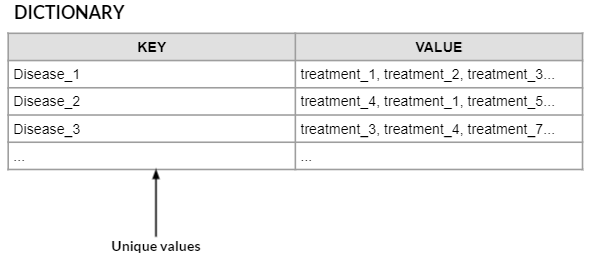

In [166]:
def get_labels_as_array(labels):
    pred_label = []

    for label in labels:
        pred_label.extend(label)
        
    return pred_label

test_frequency_df["pred_label"] = get_labels_as_array(Y_pred)
test_frequency_df.head(5)

,sentence,text,lemma,pos,label,pred_label
0,test_1,Furthermore,furthermore,ADV,O,O
1,test_1,",",",",PUNCT,O,O
2,test_1,when,when,ADV,O,O
3,test_1,all,all,DET,O,O
4,test_1,deliveries,delivery,NOUN,O,O


In [167]:
new_df = test_frequency_df[(test_frequency_df.pred_label != 'O')]
new_df.set_index('sentence',inplace=True)

disease=[]
treatment=[]
sentence=[]
med_dict = {}

for i in new_df.index.unique():
    try:
        val = new_df.loc[i,'pred_label'].unique()
        if len(val) == 2:
            disease_val = new_df[new_df.pred_label == 'D'].loc[i,'text']
            treatment_val = new_df[new_df.pred_label == 'T'].loc[i,'text']
            disease_single = disease_val if type(disease_val) == str else " ".join(disease_val)
            treatment_single = treatment_val if type(treatment_val) == str else " ".join(treatment_val)
            if disease_single not in disease:
                med_dict[disease_single] = treatment_single
            else:
                print('Entered')
                med_dict[disease_single] = med_dict.get(disease_single)+'/'+treatment_single
    except AttributeError:
        pass

print(json.dumps(dict(sorted(med_dict.items())), indent = 4))

{
    "AOM drug - resistant S. pneumoniae": "Amoxicillin remains the antibiotic of choice",
    "Barrett 's esophagus": "Acid suppression therapy",
    "Cranial nerve injuries": "persistent conduction blocks",
    "Eisenmenger 's syndrome": "laparoscopic cholecystectomy",
    "Parkinson 's disease": "Microelectrode - guided posteroventral pallidotomy",
    "Pneumocystis carinii pneumonia": "trimethoprim - sulfamethoxazole",
    "Spontaneous splenic rupture": "granulocyte colony - stimulating factor ( G - CSF )",
    "abdominal pain": "thoracic paravertebral block ( tpvb )",
    "acute carbon monoxide poisoning": "Hyperbaric or normobaric oxygen",
    "acute cerebral ischemia": "Antiplatelet therapy",
    "acute migraine treatment": "Sumatriptan",
    "acute myocardial infarction": "thrombolytic treatment",
    "acute occlusion of the middle cerebral artery": "thrombolytic therapy",
    "advanced non -- small - cell lung cancer": "paclitaxel plus carboplatin ( pc ) vinorelbine plus cisp

### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [168]:
disease=''
treatment=''

input_text = []
input_pos = []
input_label = []

input_sent = 'hereditary retinoblastoma'

input_model = model(input_sent)

for word in input_model:
    input_text.append(word.text)
    input_pos.append(word.pos_)
    input_label.append('D')

details_sent = pd.DataFrame({'text':input_text, 'pos':input_pos,'label':input_label})
words_for_features = details_sent.apply(get_word_details, axis=1)

test_sent = []

for i in range(len(input_sent.split())):
    test_sent.append(getFeaturesForOneWord(words_for_features, i))

for i,tag in enumerate(crf.predict([test_sent])[0]):
    
    if tag == 'D':
        tr = input_sent.split()[i]
        disease += tr + " "

        if tr in med_dict:
            treatment += med_dict.get(tr) + ", "
            
        if disease.strip() in med_dict:
            treatment += med_dict.get(disease.strip()) + ", "

disease = disease.strip()

if len(treatment) == 0:
    treatment = 'Not Available'
else:
    treatment = treatment.rstrip(", ")
    
print('Identified Disease   :', disease)
print('Identified Treatment :', treatment)

Identified Disease   : retinoblastoma
Identified Treatment : radiotherapy, radiotherapy
